In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/luzone/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Introduction
This analysis aimed to identify influential authors in Reddit discussions related to Israel, Judaism, and Jewish identity. The study examined their leadership influence, topic preferences, polarization levels, and sentiment trends. The approach combined quantitative metrics (post volume, replies, upvotes) with qualitative assessments (sentiment and polarization)

In [ ]:
# Load Data
posts = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/all_subreddits_submissions.csv")
comments = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/all_subreddits_comments.csv")

posts_topics = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/LDA/posts_with_lda_topics.csv")
comments_topics = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/LDA/comments_with_topics.csv")

/tmp/ipykernel_3347033/1236945760.py:2: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  posts = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/all_subreddits_submissions.csv")
/tmp/ipykernel_3347033/1236945760.py:3: DtypeWarning: Columns (4,30) have mixed types. Specify dtype option on import or set low_memory=False.
  comments = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/all_subreddits_comments.csv")
/tmp/ipykernel_3347033/1236945760.py:6: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_topics = pd.read_csv("/dt/yisroel/Users/luzone/BIG_DATA/models/LDA/comments_with_topics.csv")


In [ ]:
comments_topics['lda_topic'] = pd.to_numeric(
    comments_topics['lda_topic'],
    errors='coerce'
).fillna(-1).astype(int)

comments_topics = comments_topics[comments_topics['lda_topic'] != -1]

In [ ]:
# Filter for target subreddits
target_subreddits = ['Israel', 'Jewish', 'Judaism', 'ReformJews']
posts = posts[posts['subreddit'].isin(target_subreddits)]
comments = comments[comments['subreddit'].isin(target_subreddits)]

# Combine Topics into Posts and Comments
posts = posts.merge(posts_topics , on='id', how='inner')
comments = comments_topics.merge(comments , on='id', how='inner')

# Defining Leadership in Online Communities
In large-scale online discussions, certain individuals emerge as key contributors who actively shape discourse, engage with other users, and influence the overall sentiment of conversations. To quantify leadership in these communities, we developed a leadership score that integrates multiple engagement factors:

Leadership Score
=
(
0.3
×
num_posts
)
+
(
0.3
×
num_comments
)
+
(
0.2
×
total_post_upvotes
)
+
(
0.2
×
num_replies_received
)
Leadership Score=(0.3×num_posts)+(0.3×num_comments)+(0.2×total_post_upvotes)+(0.2×num_replies_received)
Each component was weighted to reflect both content creation and audience engagement:

Posts (30%) and Comments (30%): Users who create discussions and engage actively are often central to discourse.
Total Upvotes (20%): While upvotes indicate content appreciation, they do not always correlate with engagement.
Replies Received (20%): A high number of replies suggests that a user is a conversation driver, but it alone does not determine leadership.
This formula ensures that leadership is not solely based on popularity but also reflects meaningful participation. Alternative approaches, such as LeaderRank models (Lü et al., 2011) or linguistic-based influence models (Berger et al., 2014), could be explored in future work.




In [ ]:
top_authors

['OkBuyer1271',
 'anon755qubwe',
 'AlmightySnoo',
 'Lamplighteris9',
 'Middle_Ad_8052',
 'DatDudeOverThere',
 'antiracis',
 'welltechnically7',
 'ummmbacon',
 'lostmason',
 'woshinoemi',
 'yournextdoordude',
 'Alonn12',
 'drak0bsidian',
 '8YearLongBoner']

In [ ]:
# Filter only Top Authors' data
posts_top = posts[posts['author'].isin(top_authors)]
comments_top = comments[comments['author'].isin(top_authors)]

# Sentiment Analysis

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def get_sentiment(text):
    return analyzer.polarity_scores(str(text))['compound']

posts_top['sentiment'] = posts_top['selftext_x'].apply(get_sentiment)
comments_top['sentiment'] = comments_top['body_x'].apply(get_sentiment)

# Aggregate to Author Level
author_profile = author_stats.loc[top_authors].copy()
author_profile['avg_sentiment'] = pd.concat([posts_top, comments_top]).groupby('author')['sentiment'].mean()

/tmp/ipykernel_3347033/448131747.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_top['sentiment'] = posts_top['selftext_x'].apply(get_sentiment)
/tmp/ipykernel_3347033/448131747.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_top['sentiment'] = comments_top['body_x'].apply(get_sentiment)


# Polarization Analysis

In [ ]:
def get_polarization(text):
    if pd.isna(text) or not isinstance(text, str):
        return 0
    words = text.lower().split()
    we_count = sum(1 for word in words if word in ["we", "us", "our"])
    they_count = sum(1 for word in words if word in ["they", "them", "their"])
    return (we_count + they_count) / len(words) if len(words) > 0 else 0

posts_top['polarization'] = posts_top['selftext_x'].apply(get_polarization)
comments_top['polarization'] = comments_top['body_x'].apply(get_polarization)

author_profile['avg_polarization'] = pd.concat([posts_top, comments_top]).groupby('author')['polarization'].mean()

/tmp/ipykernel_3347033/3053291436.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_top['polarization'] = posts_top['selftext_x'].apply(get_polarization)
/tmp/ipykernel_3347033/3053291436.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_top['polarization'] = comments_top['body_x'].apply(get_polarization)


In [ ]:
author_profile.head(10)

,num_posts,avg_upvotes,total_replies_received,num_comments,leadership_score,avg_sentiment,avg_polarization
author,,,,,,,
OkBuyer1271,380.0,135.578947,13698.0,301.0,2317.336842,-0.002236,0.013574
anon755qubwe,242.0,150.061983,7363.0,2031.0,1833.059298,-0.112246,0.020981
AlmightySnoo,145.0,251.924138,6369.0,416.0,1175.938621,-0.079745,0.014396
Lamplighteris9,142.0,248.211268,5557.0,192.0,985.181690,-0.077494,0.013297
Middle_Ad_8052,188.0,164.643617,7119.0,430.0,1296.746543,-0.189364,0.014149
DatDudeOverThere,168.0,148.833333,5609.0,818.0,1176.275000,0.042777,0.010332
antiracis,131.0,203.083969,5151.0,172.0,907.112595,-0.081010,0.011688
welltechnically7,99.0,197.222222,4827.0,2920.0,1669.233333,0.074046,0.016463
ummmbacon,249.0,40.132530,1565.0,3891.0,1507.669880,0.101888,0.018385


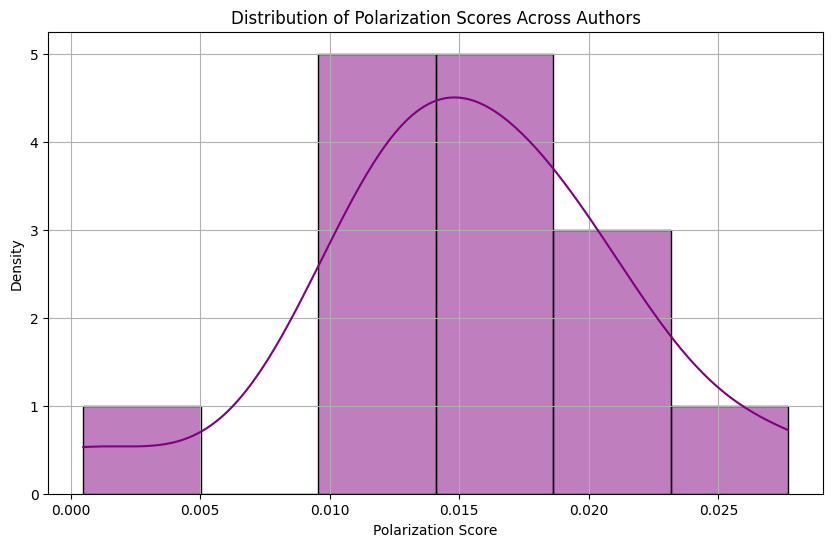

In [ ]:
# Distribution of Polarization Scores
plt.figure(figsize=(10, 6))
sns.histplot(author_profile['avg_polarization'], kde=True, color='purple')
plt.title('Distribution of Polarization Scores Across Authors')
plt.xlabel('Polarization Score')
plt.ylabel('Density')
plt.grid(True)
plt.show()

/tmp/ipykernel_3347033/466974318.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pd.cut(author_profile['avg_polarization'], bins=4, labels=["Low", "Moderate", "High", "Extreme"]),


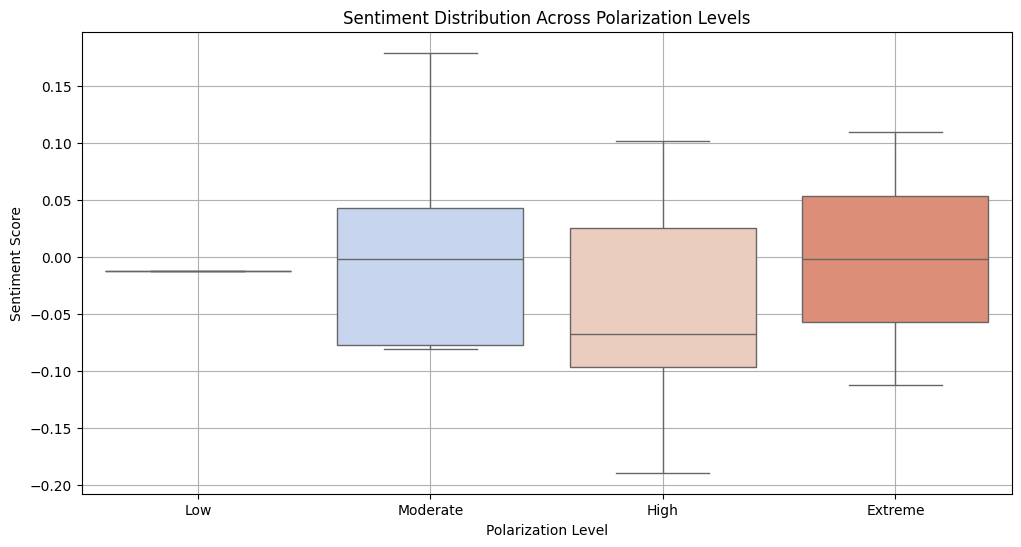

In [ ]:
# Sentiment vs Polarization
plt.figure(figsize=(12, 6))
sns.boxplot(x=pd.cut(author_profile['avg_polarization'], bins=4, labels=["Low", "Moderate", "High", "Extreme"]),
            y=author_profile['avg_sentiment'], palette='coolwarm')
plt.title('Sentiment Distribution Across Polarization Levels')
plt.xlabel('Polarization Level')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()

# Topic Dominance Per Author

In [ ]:
# Count absolute posts/comments per author-topic
posts_top['lda_topic'] = posts_top['lda_topic'].fillna(-1)
comments_top['lda_topic'] = comments_top['lda_topic'].fillna(-1)

all_topics = pd.concat([
    posts_top.groupby(['author', 'lda_topic']).size().rename("topic_count").reset_index(),
    comments_top.groupby(['author', 'lda_topic']).size().rename("topic_count").reset_index()
])

# Pivot to wide format - counts per topic per author
topic_dominance_counts = all_topics.groupby(['author', 'lda_topic'])['topic_count'].sum().unstack(fill_value=0)
print(topic_dominance_counts)

lda_topic           0    1    2    3    4    5     6     7
author                                                    
8YearLongBoner     10   36   16   41   96    9   302     8
AlmightySnoo      132   25   36   86   66    7   205     4
Alonn12            28   73   26   18   12   19   117     2
DatDudeOverThere   75   99   77   90  157   73   288   127
Lamplighteris9     16    9   29   76  120   10    61    13
Middle_Ad_8052     31   28   30  140  233   10   120    26
OkBuyer1271        50   30   51   60  220   14   151   105
anon755qubwe      253  149  113  307  387   23   982    59
antiracis          23   14   22   64   88   11    71    10
drak0bsidian       18  262   39   24   78  161   273   393
lostmason          21   14   24   33   40    6    34     5
ummmbacon          26  734  109   29  317  351  1092  1482
welltechnically7   51  456   45   91  253  150  1450   523
woshinoemi         61    2    2   66   10    1     1     4
yournextdoordude   82   57   21   75  166   11   497    

/tmp/ipykernel_3347033/1737553287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_top['lda_topic'] = posts_top['lda_topic'].fillna(-1)
/tmp/ipykernel_3347033/1737553287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_top['lda_topic'] = comments_top['lda_topic'].fillna(-1)


In [ ]:
# Save counts to author profile (this is good for analysis)
author_profile = author_profile.join(topic_dominance_counts, how='left').fillna(0)

# Normalize for heatmap (percentage of each author's total activity)
topic_dominance_fraction = topic_dominance_counts.div(topic_dominance_counts.sum(axis=1), axis=0) * 100
print(topic_dominance_fraction)

lda_topic                 0          1          2          3          4  \
author                                                                    
8YearLongBoner     1.930502   6.949807   3.088803   7.915058  18.532819   
AlmightySnoo      23.529412   4.456328   6.417112  15.329768  11.764706   
Alonn12            9.491525  24.745763   8.813559   6.101695   4.067797   
DatDudeOverThere   7.606491  10.040568   7.809331   9.127789  15.922921   
Lamplighteris9     4.790419   2.694611   8.682635  22.754491  35.928144   
Middle_Ad_8052     5.016181   4.530744   4.854369  22.653722  37.702265   
OkBuyer1271        7.342144   4.405286   7.488987   8.810573  32.305433   
anon755qubwe      11.130664   6.555213   4.971403  13.506379  17.025957   
antiracis          7.590759   4.620462   7.260726  21.122112  29.042904   
drak0bsidian       1.442308  20.993590   3.125000   1.923077   6.250000   
lostmason         11.864407   7.909605  13.559322  18.644068  22.598870   
ummmbacon          0.6280

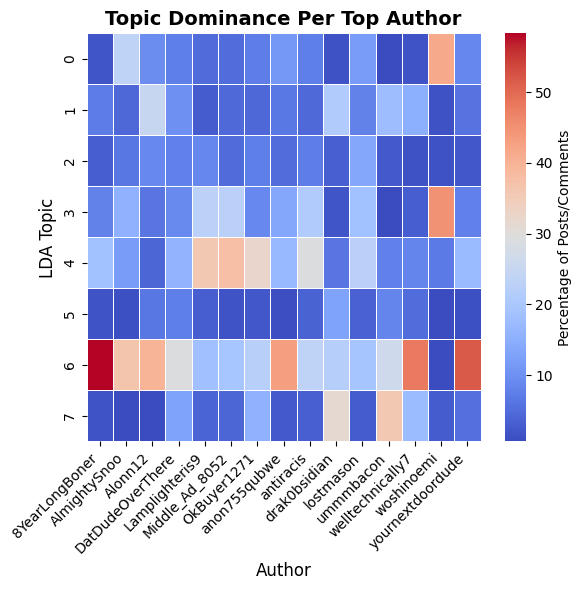

In [ ]:
# Plot heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(topic_dominance_fraction.T,
            cmap='coolwarm',
            annot=False,
            linewidths=0.5,
            cbar_kws={'label': 'Percentage of Posts/Comments'}
           )

plt.title('Topic Dominance Per Top Author', fontsize=14, fontweight='bold')
plt.xlabel('Author', fontsize=12)
plt.ylabel('LDA Topic', fontsize=12)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()

plt.show()

# Network Analysis - Who Responds to Whom

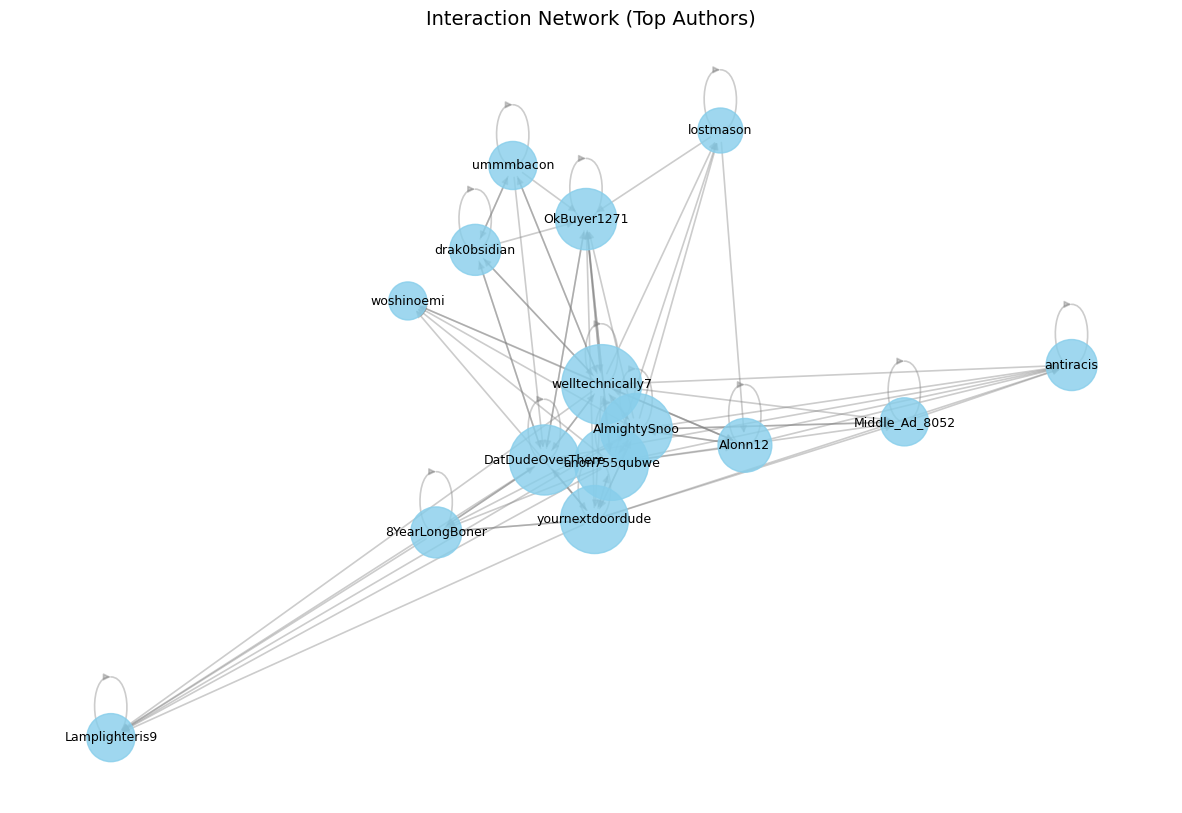

In [ ]:
G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(15, 10))

pos = nx.spring_layout(G, seed=42, k=0.5)


node_sizes = [G.degree(n) * 150 for n in G.nodes()]


nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray', width=1.2)
nx.draw_networkx_labels(G, pos, font_size=9, font_color='black')


plt.title('Interaction Network (Top Authors)', fontsize=14)
plt.axis('off')
plt.show()

In [ ]:
# Compute Network Metrics
degree_centrality = nx.degree_centrality(G)  # Number of direct connections
betweenness_centrality = nx.betweenness_centrality(G)  # Acts as a bridge
clustering_coefficient = nx.clustering(G.to_undirected())  # Forming subgroups

# Convert to DataFrame
centrality_df = pd.DataFrame({
    'degree_centrality': degree_centrality,
    'betweenness_centrality': betweenness_centrality,
    'clustering_coefficient': clustering_coefficient
}).reset_index().rename(columns={'index': 'author'})

# Sort by influence
centrality_df = centrality_df.sort_values(by='degree_centrality', ascending=False)

# Print Top Influential Users
print("Top Users by Degree Centrality:")
print(centrality_df.head(10))

Top Users by Degree Centrality:
              author  degree_centrality  betweenness_centrality  \
5   welltechnically7           1.571429                0.251190   
2       anon755qubwe           1.357143                0.061722   
10      AlmightySnoo           1.285714                0.144597   
1   DatDudeOverThere           1.214286                0.082143   
3   yournextdoordude           1.142857                0.030495   
0        OkBuyer1271           0.928571                0.046612   
11           Alonn12           0.714286                0.099634   
6          antiracis           0.642857                0.000000   
4     8YearLongBoner           0.642857                0.001374   
13      drak0bsidian           0.642857                0.005678   

    clustering_coefficient  
5                 0.474359  
2                 0.545455  
10                0.545455  
1                 0.555556  
3                 0.622222  
0                 0.607143  
11                0.800000 

In [ ]:
# Modularity Detection (Community Structure)
from networkx.algorithms import community

# Use Girvan-Newman algorithm to detect communities
comp = community.girvan_newman(G)
first_partition = tuple(sorted(c) for c in next(comp))  # First level of modularity

# Convert to DataFrame
modularity_df = pd.DataFrame({
    'author': [node for group in first_partition for node in group],
    'community': [i for i, group in enumerate(first_partition) for _ in group]
})

# Merge with Centrality Data
network_results = centrality_df.merge(modularity_df, on='author', how='left')

# Print Modular Communities
print("\nDetected Communities:")
print(modularity_df.groupby('community')['author'].apply(list))


Detected Communities:
community
0    [8YearLongBoner, AlmightySnoo, Alonn12, DatDud...
1                                       [drak0bsidian]
Name: author, dtype: object


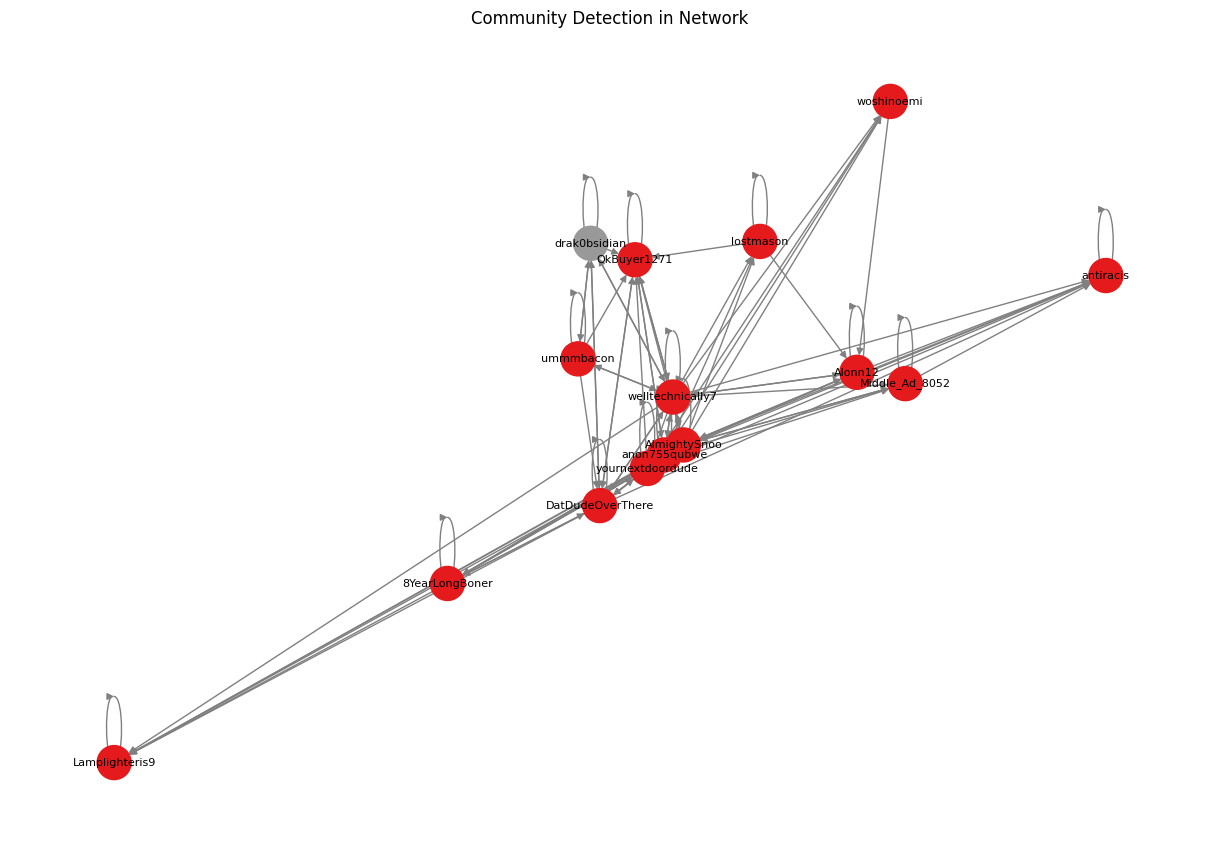

In [ ]:
# Visualizing Communities
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
colors = [network_results.set_index('author').loc[node]['community'] if node in network_results['author'].values else 0 for node in G.nodes()]
nx.draw(G, pos, node_color=colors, cmap=plt.cm.Set1, with_labels=True, node_size=600, font_size=8, edge_color='gray')
plt.title("Community Detection in Network")
plt.show()

In [ ]:
# Printing Example Posts for High-Polarization Authors
high_polarization_authors = author_profile.nlargest(3, 'avg_polarization').index

for author in high_polarization_authors:
    print(f"\n=== Example Posts by {author} (High Polarization) ===\n")
    example_posts = posts_top[posts_top['author'] == author]['selftext_x'].dropna().sample(3, random_state=42).tolist()
    for i, post in enumerate(example_posts, 1):
        print(f"Post {i}:\n{post}\n")


=== Example Posts by Alonn12 (High Polarization) ===

Post 1:
In this megathread rules will be applied very harshly and strictly so be aware of that

Post 2:
due to recent events it is important to remind you all about this rule, it may seem infuriating or bizzare, but trust us, we have good reason to remove those.

Rule 4 - No Combat Footage

Do not upload photos or videos of war footage directly to the sub. This includes footage of airstrikes, aftermath, battlefields etc.

Please link to an article or other credible source that contains this type of content instead. These posts need to be marked as NSFW and may be removed at moderator’s discretion.

Post 3:
Greetings all, over the past few weeks we have seen a vast increase in complaints on the validity of the Israeli newspaper, [Haaretz](https://www.haaretz.com/). as some of you may know Haaretz has some opinions some might consider extreme. some voices in the community have asked for Haaretz to be added to the banned sources [(lin

In [ ]:
print("Top Authors - Profile Summary")
print(author_profile[['leadership_score', 'avg_sentiment', 'avg_polarization']].sort_values('leadership_score', ascending=False))

Top Authors - Profile Summary
                  leadership_score  avg_sentiment  avg_polarization
author                                                             
OkBuyer1271            2317.336842      -0.002236          0.013574
anon755qubwe           1833.059298      -0.112246          0.020981
welltechnically7       1669.233333       0.074046          0.016463
ummmbacon              1507.669880       0.101888          0.018385
Middle_Ad_8052         1296.746543      -0.189364          0.014149
drak0bsidian           1273.533182       0.179015          0.011132
yournextdoordude       1225.154808      -0.023380          0.019670
DatDudeOverThere       1176.275000       0.042777          0.010332
AlmightySnoo           1175.938621      -0.079745          0.014396
Alonn12                1006.680233       0.109123          0.027684
Lamplighteris9          985.181690      -0.077494          0.013297
antiracis               907.112595      -0.081010          0.011688
8YearLongBoner    